Consideramos el problema de difusión:

$$-\phi_{xx}=0 \hspace{0.8em} (t,x) \in (0,1) \times (0,2)$$
$$\phi(t,0)=0; \phi(t,1)=1 \hspace{0.8em} t \in (0,1)$$
$$\phi(0,x) = \sigma(M(x-1/2))$$

Consideramos $c=1$ en este caso.

Esto no converge, he visto que se utilizan redes neurales de prueba es decir reducir el numero de parámetros o modificar la arquitectura.

https://arxiv.org/pdf/2104.05512.pdf

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
DTYPE='float32'

2024-04-13 19:54:10.657625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 19:54:10.657689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 19:54:10.659686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 19:54:10.672685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 19:54:12.347679: W tensorflow/compiler/tf2tenso

# Aux Functions

In [2]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20, add_last_layer=1):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input([2]))

    # Introduce a scaling layer to map input to [lb, ub]
    #scaling_layer = tf.keras.layers.Lambda(
    #            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation="sigmoid", use_bias=True))

    # Output is one-dimensional
    if(add_last_layer):
        model.add(tf.keras.layers.Dense(1, activation=None))
        
    model.summary()
    return model

In [3]:
def get_gradient(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, y = X_r[:, 0:1], X_r[:,1:2]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        u = model(tf.stack([x[:,0], y[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)

    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    return fun_r(x,u_x,u_y,u_xx,u_yy)

In [4]:
def symmetry(x):
    aux = x.numpy()

    aux[:, 1] = 2
    return tf.convert_to_tensor(aux)

In [5]:
def compute_loss(model, X_r, periodic_points_1, periodic_points_2, t0_points):

    # Compute phi^r
    r  = get_gradient(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss_XR = phi_r
    
    # Periodic 
    
    loss_boundary = tf.reduce_mean(tf.square(model(periodic_points_1)- 0))
    loss_boundary += tf.reduce_mean(tf.square(model(periodic_points_1)- 1))
    # TN Point DUDAS
    
    loss_T0 = tf.reduce_mean(tf.square(model(t0_points)-eval))
    
    #x, y, u_x, u_y, u_xx, u_yy = get_gradient(model, tn_points)
    #tn_error=tf.pow(tf.square(u_x)+ tf.square(u_y), 1/2)-g(x,y)
    #tn_error=tf.reduce_sum(tf.square(tn_error), axis=0)
    #loss += tn_error
    loss = loss_XR + loss_boundary+loss_T0

    return loss

In [15]:
def get_grad(model, X_r, td_points_1, td_points_2, tn_points):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, td_points_1, td_points_2, tn_points)

    g = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, g

In [7]:
from time import time

def train(mlp):
    # Define one training step as a TensorFlow function to increase speed of training
    @tf.function
    def train_step():
        # Compute current loss and gradient w.r.t. parameters
        loss, grad_theta = get_grad(mlp, X_r, bound_points_1, bound_points_2, t0_points)

        # Perform gradient descent step
        optim.apply_gradients(zip(grad_theta, mlp.trainable_variables))

        return loss

    # Number of training epochs
    N = 20000
    hist = []

    # Start timer
    t0 = time()

    for i in range(N+1):

        loss = train_step()

        # Append current loss to hist
        hist.append(loss.numpy())

        # Output current loss after 50 iterates
        if i%50 == 0:
            print('It {:05d}'.format(i))
            print('loss: ', loss.numpy())

    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

# Training

In [21]:
# Initial Condition


C=1000
def f(x):
    return 1/(1+np.exp(-C*(x-1/2)))


C=700
def exact_sol(m):
    return 0*m


'''
def f(x):
    # Perform the comparison
    comparison = tf.logical_and(tf.greater(x, 1/3), tf.less(x, 2/3))

    # Convert boolean values to integers (1 for True, 0 for False)
    result = tf.cast(comparison, tf.float32)
    return result

def exact_sol(m):
    result = []
    for value in m:
        if 1/3 < value < 2/3:
            result.append(1)
        else:
            result.append(0)
    return result
'''

# Condition for the equation
c=1
def fun_r(x, u_x, u_t, u_xx, u_tt):
    return -u_xx

In [17]:
# Parameters

# Number of Data points
N_t0=1000 # For initial condition
N_periodic=1000 # For periodic Condition
N_r=3000 # For Random points inside the domain

# Rectangular domain for which we are solving
xmin=0
xmax=2
tmin=0
tmax=1

In [18]:
# Creation of points

# Lower bounds
lb = tf.constant([xmin, tmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, tmax], dtype=DTYPE)

# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)

X_r = tf.concat([x_r, y_r], axis=1)

# t0
aux = tf.random.uniform((N_t0,1), lb[0], ub[0], dtype=DTYPE)
aux1 = tf.ones((N_t0, 1), dtype=DTYPE)*lb[0]

eval = tf.map_fn(f, aux)
t0_points=tf.concat([aux1, aux], axis=1)


# boundary
aux = tf.random.uniform((N_periodic,1), lb[1], ub[1], dtype=DTYPE)
aux1 = tf.ones((N_periodic, 1), dtype=DTYPE)*lb[0]
bound_points_1 = tf.concat([aux, aux1], axis=1)

aux = tf.random.uniform((N_periodic,1), lb[1], ub[1], dtype=DTYPE)
aux1 = tf.ones((N_periodic, 1), dtype=DTYPE)*lb[0]
bound_points_2 = tf.concat([aux, aux1], axis=1)

/home/alexpf/Projects/ED-Solve/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py:460: RuntimeWarning: overflow encountered in exp
  return f(*args)


In [23]:
mlp = init_model(10, 5)
optim=tf.keras.optimizers.Adam(learning_rate=0.5)

train(mlp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 15        
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
 dense_10 (Dense)            (None, 5)                

KeyboardInterrupt: 

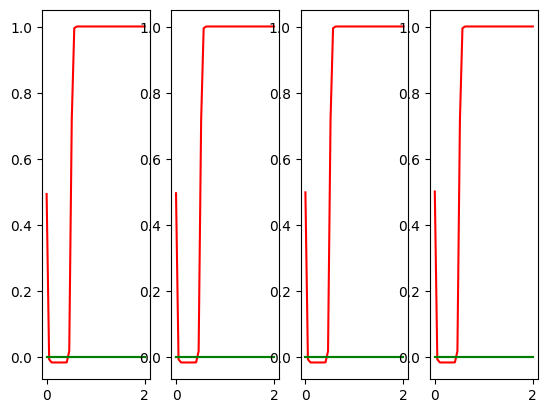

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
def model_summary(mlp):
    t0=0
    x=np.linspace(0,3)
    t=np.zeros((len(x), 2))
    t[:, 1] = x
    t[:,0] = t0    

    fig, ax = plt.subplots(1, 4)

    t=np.linspace(tmin, tmax, 4)
    x = np.linspace(xmin, xmax, 40)

    concat = np.zeros((len(x),2))
    concat[:, 1] = x

    def plot(i,t):
        concat[:,0]= t
        ax[i].plot(x, mlp(concat), color="red", label=f"Tiempo={t}")
        ax[i].plot(x, exact_sol(concat), color ="green", label=f"Tiempo={t}")
        

    for i in range(4):
        plot(i, t[i])


    plt.show()
    mlp.summary()

model_summary(mlp)